Análisis de publicaciones sobre analytics y big data en Scopus
===

En este tutorial se ejemplifica la realización del análisis exploratorio de datos aplicado a las revistas listadas en Scopus que contienen en sus nombres las palabras *big data*, *data science*, *business intelligence* y *analitics*.

In [1]:
##
## Preparacion
##
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
alt.renderers.enable('notebook');
%matplotlib inline
%load_ext rpy2.ipython

## Descripción de la información

El archivo `scopus-papers.csv` contiene la información bibliográfica de los artículos seleccionados. Los nombres de las columnas son autoexplicativos.

In [2]:
## Nombres de las columnas
!head -n 1 scopus-papers.csv | tr ',' '\n'

﻿Authors
Author(s) ID
Title
Year
Source title
Volume
Issue
Art. No.
Page start
Page end
Page count
Cited by
DOI
Link
Affiliations
Authors with affiliations
Author Keywords
Index Keywords
Document Type
Publication Stage
Access Type
Source
EID


El archivo `scopus-abstracts.csv` contienen los abstracs de los artículos seleccionados.

In [3]:
## Nombres de las columnas
!head -n 1 scopus-abstracts.csv | tr ',' '\n'

﻿DOI
Link
Abstract


## Carga de la información

In [5]:
##
## Lectura de datos
##
papers = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/playground/master/datasets/scopus-papers.csv",
                     sep = ',',           # separador de campos
                     thousands = None,    # separador de miles para números
                     decimal = '.',       # separador de los decimales para números
                     encoding='latin-1')  # idioma
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 23 columns):
Authors                      1902 non-null object
Author(s) ID                 1902 non-null object
Title                        1902 non-null object
Year                         1902 non-null int64
Source title                 1902 non-null object
Volume                       1860 non-null float64
Issue                        1456 non-null object
Art. No.                     531 non-null object
Page start                   1411 non-null object
Page end                     1411 non-null object
Page count                   2 non-null float64
Cited by                     1257 non-null float64
DOI                          1825 non-null object
Link                         1902 non-null object
Affiliations                 1889 non-null object
Authors with affiliations    1899 non-null object
Author Keywords              1793 non-null object
Index Keywords               828 non-null obj

In [6]:
##
## Lectura de datos
##
abstracts = pd.read_csv("https://raw.githubusercontent.com/jdvelasq/playground/master/datasets/scopus-abstracts.csv",
                        sep = ',',           # separador de campos
                        thousands = None,    # separador de miles para números
                        decimal = '.',       # separador de los decimales para números
                        encoding='latin-1')  # idioma
abstracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 3 columns):
DOI         1825 non-null object
Link        1902 non-null object
Abstract    1902 non-null object
dtypes: object(3)
memory usage: 44.7+ KB


## Nombres de las revistas

In [6]:
sorted(papers['Source title'].unique())

['Applied Marketing Analytics',
 'Big Data',
 'Big Data Research',
 'Big data',
 'Data Science Journal',
 'Data Science and Engineering',
 'EPJ Data Science',
 'Easy Care in Wool; Woolmark Business Intelligence July 1999',
 'Environment and Planning B: Urban Analytics and City Science',
 'International Journal of Business Analytics',
 'International Journal of Business Intelligence Research',
 'International Journal of Business Intelligence and Data Mining',
 'Journal of Big Data',
 'Journal of Management Analytics',
 'Journal of Marketing Analytics',
 'World Wool Supply to 2005; Woolmark Business Intelligence July1999']

In [7]:
##
## Cantidad de revistas
##
len(papers['Source title'].unique())

16

## Cantidad de citas por año por revista

In [8]:
df = papers.groupby(['Source title']).sum()[['Cited by']].sort_values('Cited by', ascending = False)
df

,Cited by
Source title,
Journal of Big Data,2312.0
EPJ Data Science,1902.0
Data Science Journal,1468.0
International Journal of Business Intelligence and Data Mining,1420.0
Big Data,1164.0
Big Data Research,926.0
Journal of Management Analytics,440.0
Environment and Planning B: Urban Analytics and City Science,370.0
Journal of Marketing Analytics,253.0


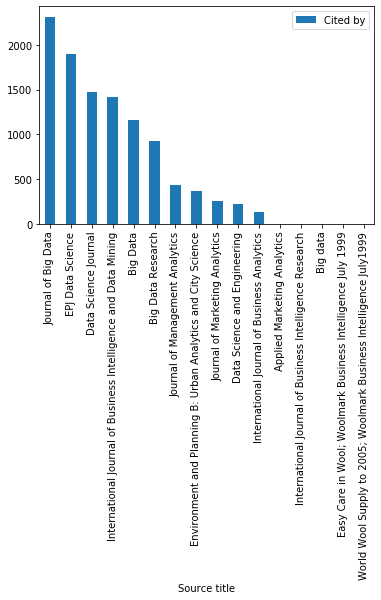

In [9]:
##
## Gráfico por defecto usando Matplotlib
##
df.plot.bar();

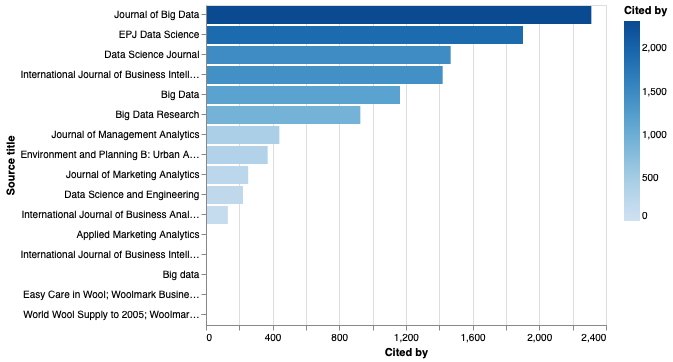

In [10]:
##
## Gráfico usando Altair
##
df['Source title'] = [p for p in df.index]
alt.Chart(df).mark_bar().encode(
    y = alt.Y('Source title:N', sort=alt.EncodingSortField(field='Cited by:Q')),
    x = 'Cited by:Q',
    color = 'Cited by:Q'
)

## Total de citas por año

In [11]:
##
## Suma de citas agregada por título y año
##
df = papers.groupby(['Source title', 'Year']).sum()[['Cited by']]

##
## Los ejes para la gráfica deben ser campos
## en el DataFrame
##
df['Source title'] = [p[0] for p in df.index]
df['Year'] = [p[1] for p in df.index]
df.index = range(len(df))
df[0:5]

,Cited by,Source title,Year
0,2.0,Applied Marketing Analytics,2018
1,0.0,Applied Marketing Analytics,2019
2,543.0,Big Data,2013
3,170.0,Big Data,2014
4,203.0,Big Data,2015


/home/vagrant/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


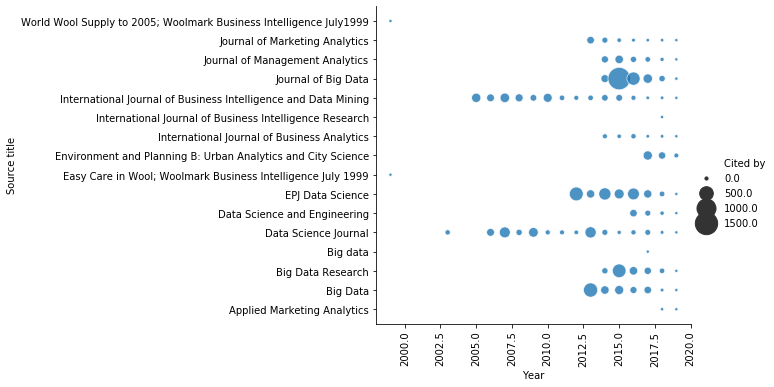

In [12]:
sns.relplot(x = 'Year',
            y = 'Source title',
            size = 'Cited by',
            sizes = (10, 500),
            alpha = 0.8,
            palette = 'viridis',
            data = df);
plt.xticks(rotation=90);

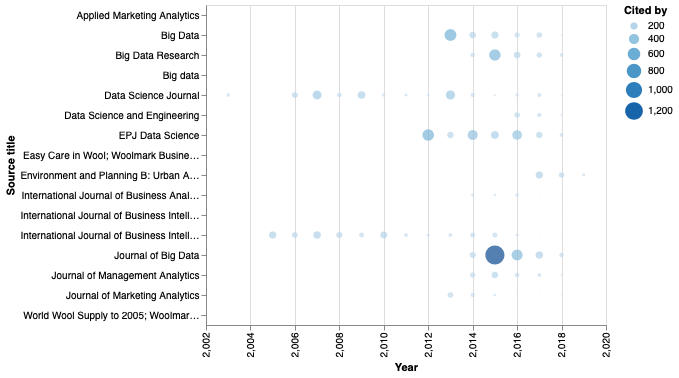

In [13]:
alt.Chart(df).mark_circle().encode(
    alt.X('Year:Q', 
          scale=alt.Scale(domain=(2002, 2019)), 
          axis=alt.Axis(labelAngle=270)),
    alt.Y('Source title:N'),
    size='Cited by',
    color='Cited by'
)

## Palabras claves más frecuentes

In [14]:
## 
## Elimina los registros con valor NaN
##
words_temp = papers['Author Keywords'].map(lambda x: x if isinstance(x, str) else '')

##
## Convierte el string en una lista de palabras por registro
words_temp = [w.split(';') for w in words_temp]

##
## Elimina los espacios en blanco al principio y
## final de cada palabra clave y convierte la 
## cadena en minúsculas
##
words_temp = [[e.strip().lower() for e in w if e.strip() != ''] for w in words_temp]

##
## Genera un registro por cada palabra clave
##
words = []
for w in words_temp:
    words.extend(w)

words_wc = words
##
## Crea un DataFrame para realizar el conteo
##
words = pd.DataFrame({'word':words, 'N':1})

##
## Cuenta agregado por keyword
##
words = words.groupby('word').sum().sort_values(by='N', ascending = False)
words['word'] = words.index
words.index = range(len(words))

##
## Las 10 palabras más citadas
##
words[0:10]

,N,word
0,167,big data
1,134,data mining
2,57,machine learning
3,41,clustering
4,37,big data analytics
5,33,classification
6,31,business intelligence
7,30,metadata
8,29,social media
9,26,mapreduce


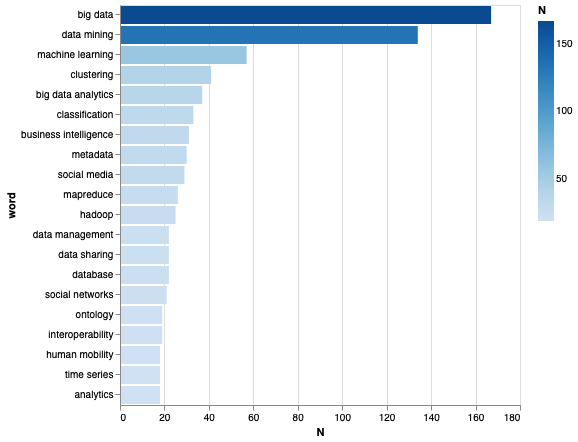

In [15]:
alt.Chart(words[0:20]).mark_bar().encode(
    x = 'N:Q',
    y = alt.Y('word:N', sort=alt.EncodingSortField(field='N:Q')),
    color = 'N:Q'
)

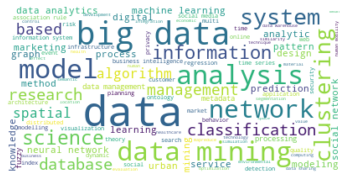

In [16]:
from wordcloud import WordCloud, ImageColorGenerator

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(words_wc))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Contribuciones por país de origen

Uno de los gráficos comúnmente usados en los mapeos sistemáticos de literatura es la cantidad de artículos por país de origen. Este gráfico da una idea de en que lugares se está concentrando la investigación sobre el tópico abordado. A continuación se describe el código para este gráfico.

In [17]:
##
## Reemplaza los campos que no son string por ''
##
affiliations = papers['Affiliations'].map(lambda x: x if isinstance(x, str) else '')

##
## Obtiene la afiliación por autor
##
affiliations = [affiliation.split(';')  for  affiliation in affiliations if affiliation != '']

## 
## Genera una lista con una afiliación 
## por elemento y crea un DataFrme
##
z = []
for w in affiliations:
    z.extend(w)
z = [e.split(',')[-1].strip() for e in z]   
z = [e for e in z if not e.isdigit()]   

affiliations = pd.DataFrame({'country': z, 'q':1})

##
## Separa los campos de la afiliación por comas
##
affiliations['country'] = affiliations['country'].map(lambda x: x.split(','))

##
## El último campo es el país de affiliación
##
affiliations['country'] = affiliations['country'].map(lambda x: x[-1])

## 
## Suma los registros por país
##
countries = affiliations.groupby('country').sum()        
countries = countries.sort_values('q', ascending = False) 

##
## DataFrame con la cantidad de artículos por país
##
countries[0:10]

,q
country,
United States,1089
China,457
India,295
United Kingdom,250
Japan,239
Italy,175
Germany,124
Australia,121
Canada,93


In [18]:
##
## Importa geopandas y la información para construir el gráfico
##
import geopandas
import geoplot


##
## Carga el DataFrame con la información general 
## del gráfico
##
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

##
## Elimina la Antártica
##
world = world[world.name!="Antarctica"]

##
## Se genera una lista con los países
##
worldList = world['name'].tolist()

##
## Los nombres de los países obtenidos de los artículos
## no coinciden necesariamente con los existentes en 
## el DataFrame world. 
## 
## Palabras que están en la lista de países de geopandas
## pero que no aparecen en los países listados en los papers
##
[w for w in sorted(worldList) if w not in countries.index.tolist()]

['Afghanistan',
 'Albania',
 'Angola',
 'Bahamas',
 'Belarus',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herz.',
 'Botswana',
 'Brunei',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Central African Rep.',
 'Chad',
 'Congo',
 'Cuba',
 'Czechia',
 "Côte d'Ivoire",
 'Dem. Rep. Congo',
 'Djibouti',
 'Dominican Rep.',
 'El Salvador',
 'Eq. Guinea',
 'Eritrea',
 'Estonia',
 'Falkland Is.',
 'Fiji',
 'Fr. S. Antarctic Lands',
 'Gabon',
 'Gambia',
 'Ghana',
 'Greenland',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',
 'Haiti',
 'Honduras',
 'Iceland',
 'Iraq',
 'Jamaica',
 'Kazakhstan',
 'Kosovo',
 'Kuwait',
 'Kyrgyzstan',
 'Laos',
 'Latvia',
 'Lesotho',
 'Liberia',
 'Libya',
 'Lithuania',
 'Macedonia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Moldova',
 'Mongolia',
 'Montenegro',
 'Myanmar',
 'N. Cyprus',
 'New Caledonia',
 'Nicaragua',
 'Niger',
 'North Korea',
 'Oman',
 'Panama',
 'Papua New Guinea',
 'Paraguay',
 'Peru',
 'Puerto Rico',
 'Russia

In [19]:
## 
## Palabras que están en la lista de países de los papers
## pero que no aparecen en los países de geopandas
##
[w for w in sorted(countries.index.tolist()) if w not in worldList]

['Amman',
 'CAS',
 'CASS',
 "Cote d'Ivoire",
 'Czech Republic',
 'Department of Information Management',
 'French Polynesia',
 'Gradute Univ. of CAS',
 'Hong Kong',
 'Libyan Arab Jamahiriya',
 'Madurai',
 'Mauritius',
 'Melmaruvathur',
 'Open Culture International Association',
 'Peking University',
 'RTL â\x80\x93 RTL',
 'Russian Federation',
 'Singapore',
 'Syrian Arab Republic',
 'Tamil Nadu',
 'Tamil Nadu  630 561',
 'Thinghua University',
 'Think3 Inc.',
 'United States',
 'Viet Nam']

In [20]:
##
## A continuación se corrigen las diferencias
##
new_index = countries.index.tolist()
new_index = ['United States of America' if x == 'United States' else x for x in new_index]
new_index = ['Russia' if x == 'Russian Federation' else x for x in new_index]
new_index = ['Syria' if x == 'Syrian Arab Republic' else x for x in new_index]
new_index = ['Vietnam' if x == 'Viet Nam' else x for x in new_index]

##
## Se asigna el nuevo índice con los nombres corregidos
##
countries.index = new_index

In [21]:
##
## Agrega el conteo al DataFrame
##
world.index = world['name'].tolist()
world['q'] = 0
for country in countries.index.values.tolist():
    world.at[country, 'q'] = countries.loc[country].q 

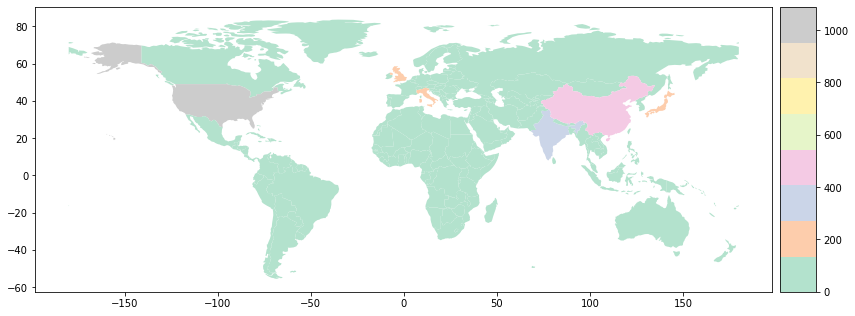

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='q',  legend=True, ax=ax, cax=cax, cmap='Pastel2');

## Apéndice --- worldmap en Altair

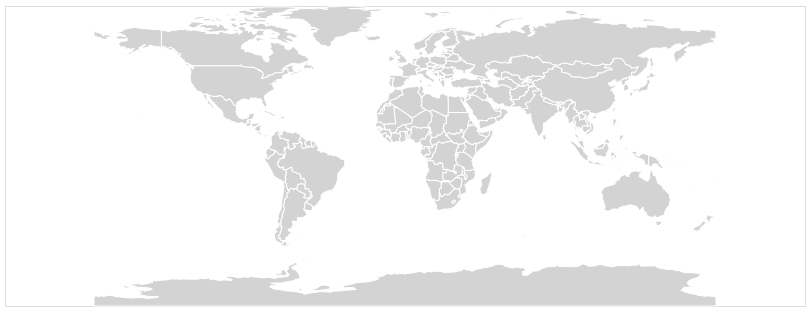

In [23]:
from vega_datasets import data

source = alt.topo_feature(data.world_110m.url, 'countries')

data = pd.DataFrame({'id':['Canada', 'Colombia'],
                     'value': ['yellow', 'red']})

alt.Chart(source).mark_geoshape(
    fill='lightgray',
    color='value:N',
    stroke='white'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(data, 'id', ['value'])
).properties(
    width=800,
    height=300
).project('equirectangular')

